# Podstawy Sztucznej Inteligencji - Projekt Kacper Marzol

Celem tego projektu jest klasyfikacja piosenek na podstawie ich kilku cech. Zbiór danych składa się z 278 tysięcy piosenek z serwisu Spotify. Dla szybkości obliczeń, użyjemy niepełnych danych.

https://www.kaggle.com/datasets/abdullahorzan/moodify-dataset

In [30]:
import pandas as pd

data = pd.read_csv("data/278k_labelled_uri.csv")
data=data.iloc[:139000, :]
print(data.shape)


(139000, 15)


In [31]:
data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'duration (ms)', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'spec_rate', 'labels', 'uri'],
      dtype='object')

* Acousticness: miara akustyczności od 0 do 1
* Danceability: miara taneczności od 0 do 1
* Energy: miara energiczności od 0 do 1
* Instrumentalness: miara instrumentalności od 0 do 1
* Liveness: miara obecności publiki w nagraniu od 0 do 1
* Loudness: miara głośnośći w decybelach (-60 do 0 decybeli)
* Speechiness: miara słów w piosence od 0 do 1
* Valence: miara od 0 do 1 opisująca pozytywność przekazywaną przez piosenkę
* Tempo: tempo piosenki w BMP (uderzeń na minutę)

In [3]:
data.labels.value_counts()

1    49898
0    42289
2    26508
3    20305
Name: labels, dtype: int64

* 0 - piosenka smutna
* 1 - piosenka wesoła
* 2 - piosenka energetyczna
* 3 - piosenka spokojna

Usuniemy zbędne kolumny, "uri", ponieważ URL piosenki nie jest potrzebny oraz dwie pierwsze kolumny

In [4]:
cols=["Unnamed: 0.1", "Unnamed: 0","uri"]
data=data.drop(cols ,axis=1)

In [5]:
data.head()

,duration (ms),danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,spec_rate,labels
0,195000.0,0.611,0.614,-8.815,0.0672,0.0169,0.000794,0.7530,0.520,128.050,3.446154e-07,2
1,194641.0,0.638,0.781,-6.848,0.0285,0.0118,0.009530,0.3490,0.250,122.985,1.464234e-07,1
2,217573.0,0.560,0.810,-8.029,0.0872,0.0071,0.000008,0.2410,0.247,170.044,4.007850e-07,1
3,443478.0,0.525,0.699,-4.571,0.0353,0.0178,0.000088,0.0888,0.199,92.011,7.959809e-08,0
4,225862.0,0.367,0.771,-5.863,0.1060,0.3650,0.000001,0.0965,0.163,115.917,4.693131e-07,1


Dodamy trochę nanów do zbioru

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

X = data.drop('labels', axis=1)
y = data.labels

ix = [(row, col) for row in range(X.shape[0]) for col in range(X.shape[1])]
for row, col in random.sample(ix, int(round(.1*len(ix)))):
    X.iat[row, col] = np.nan

X.isna().sum()

duration (ms)       13796
danceability        13893
energy              13951
loudness            14153
speechiness         13977
acousticness        13874
instrumentalness    13922
liveness            13846
valence             13834
tempo               13843
spec_rate           13811
dtype: int64

Podzielimy zbiór na część treningową, walidacyjną i testową:

In [7]:
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(X_val.shape)

(111200, 11)
(111200,)
(13900, 11)
(13900, 11)


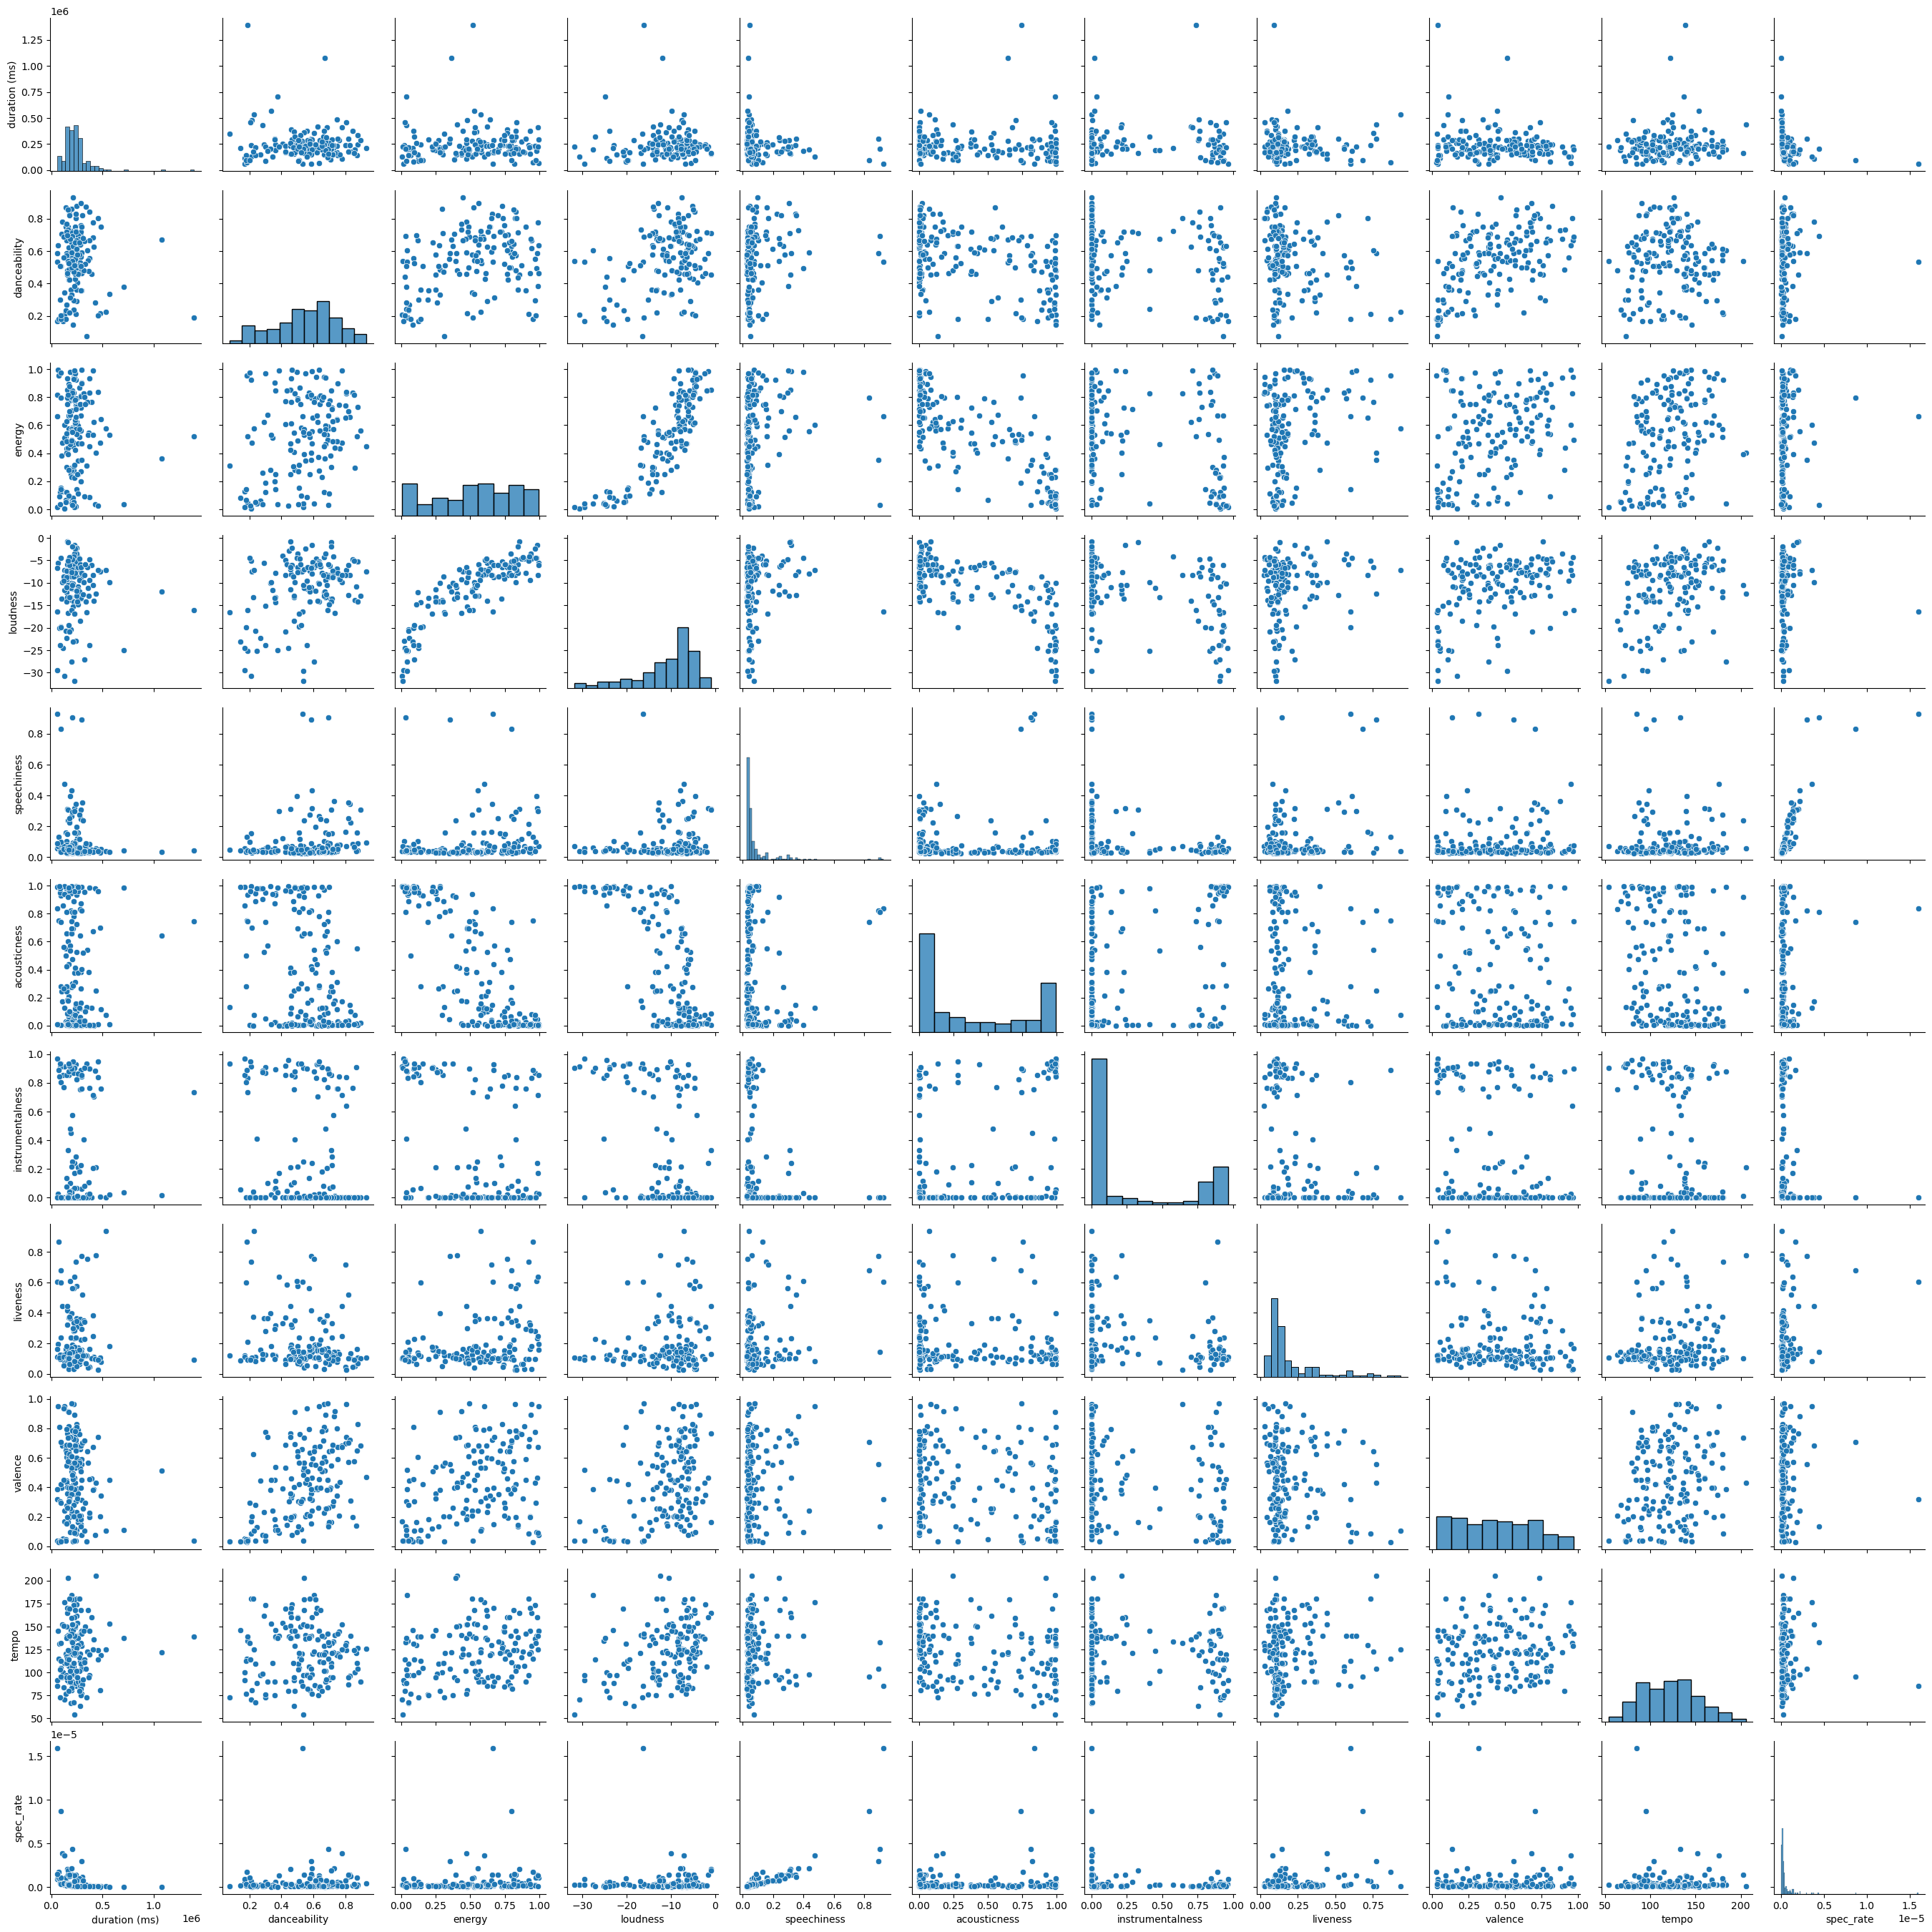

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

xplot=X_train.iloc[:200, :]
sns.pairplot(xplot)
plt.show()

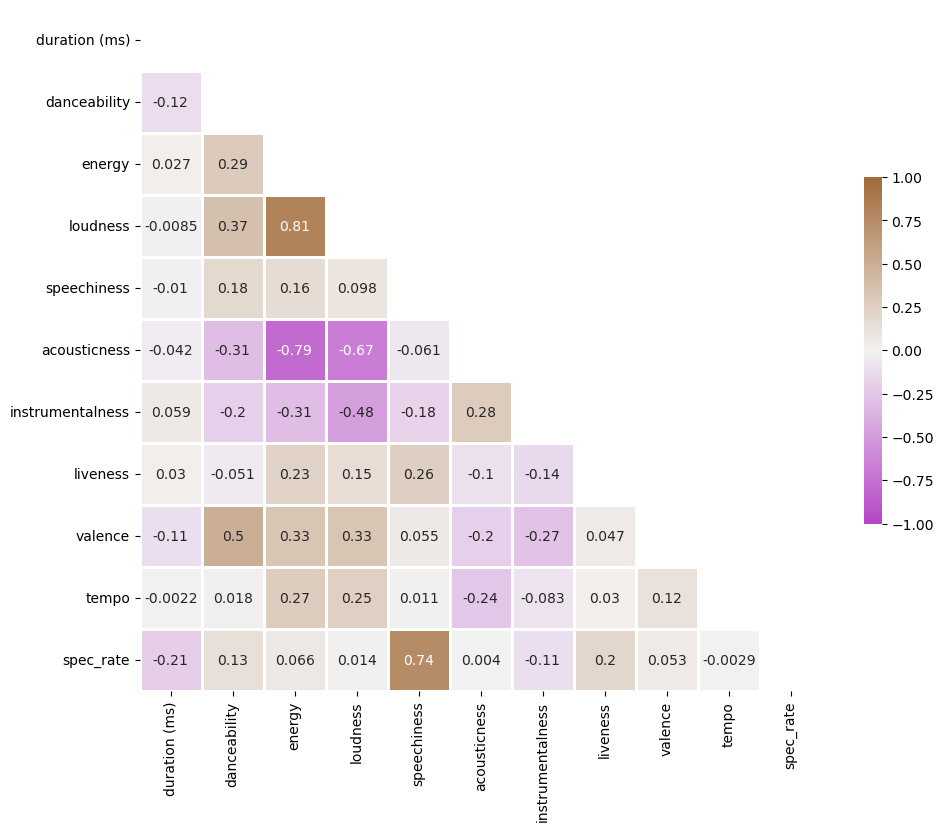

In [9]:
corr = X_train.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(300,400 , as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1,
            square=True, xticklabels=1, yticklabels=1,
            linewidths=1, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

Zauważamy kilka dodatnich i wysokich korelacji, które wydają się oczywiste (np. loudness i energy)

# Nauczymy kilka modeli

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

models=[]
model_names=[]
accuracy=[]

# Logistic Regression

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

def pipeline_maker(model):
    return make_pipeline(SimpleImputer(strategy="median"), StandardScaler(), model)

def test (model, param_grid_):
    pipe=pipeline_maker(model)
    search=GridSearchCV(pipe, param_grid=param_grid_,scoring='accuracy')
    search.fit(X_train, y_train)
    return search.best_estimator_, search.cv_results_

In [12]:
from sklearn.linear_model import LogisticRegression

logistic=LogisticRegression()

param_grid={
    'simpleimputer__strategy': ['mean', 'median'],
    "logisticregression__C": [0.0001,0.001,0.01,0.1,1,10,100,1000]
}

logistic, scores = test(logistic, param_grid)

results = pd.DataFrame(scores)

models.append(logistic)
model_names.append("Logistic Regression")
y_pred=logistic.predict(X_val)
accuracy.append(accuracy_score(y_val,y_pred))

In [13]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=0.01))])


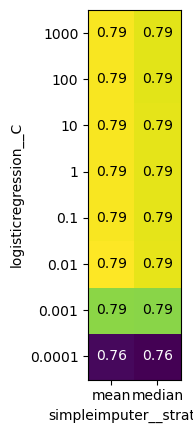

In [14]:
print(logistic)
scores = np.array(results.mean_test_score).reshape(8, 2, 1)
scores = scores[:,:,0]
# plot the mean cross-validation scores
heatmap(scores, xlabel='simpleimputer__strategy', xticklabels=param_grid['simpleimputer__strategy'], ylabel='logisticregression__C', yticklabels=param_grid['logisticregression__C'], cmap="viridis")
plt.show()


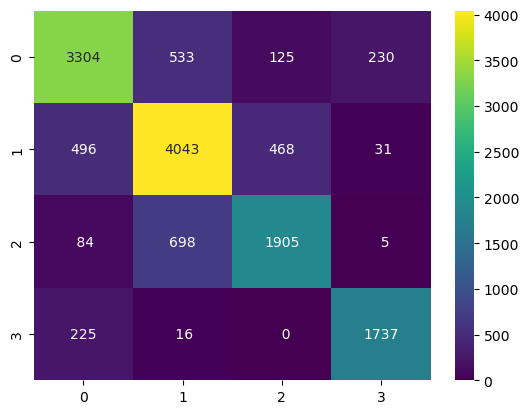

accuracy:  0.7905755395683454


{'precision': 0.8040885860306644,
 'recall': 0.7881679389312977,
 'f1-score': 0.7960486688350801,
 'support': 4192}

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

cr= classification_report(y_val, y_pred,  output_dict=True)
print("accuracy: " , accuracy[-1])
cr['0']


Accuracy na poziomie 0.793, widzimy, że model stosunkowo często myli 1 z 0 2, czyli piosenki wesołe ze smutnymi i energetycznymi.

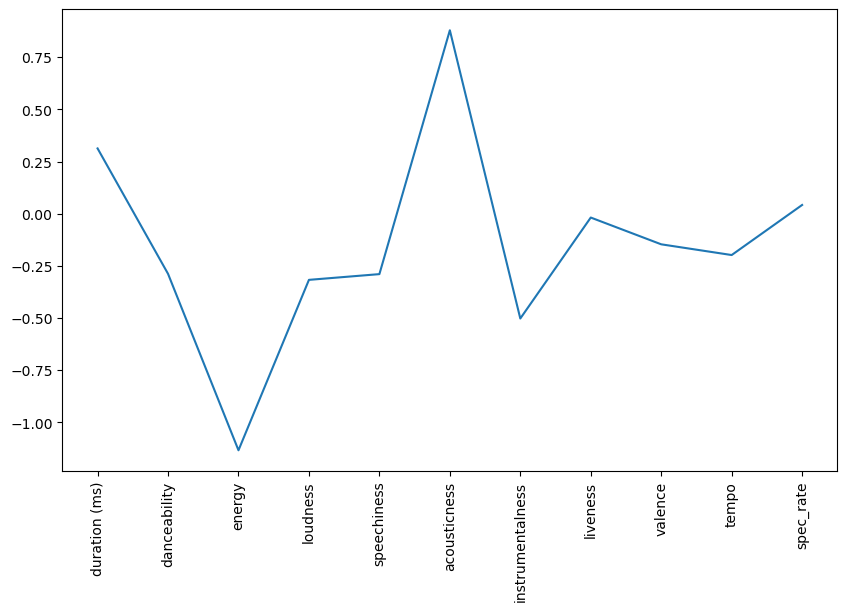

In [16]:
f, ax = plt.subplots(1,1,figsize=(10,6))

x=range(11)

columns = X.columns.tolist()

w=logistic["logisticregression"].coef_[0].reshape(-1,1)
ax.plot(x,w)

# print(data.columns)
ax.set_xticks(x)
ax.set_xticklabels(columns,rotation=90)

plt.show()

# Random Forests

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()

param_grid = {
    'randomforestclassifier__n_estimators': [10,20,30],
    'randomforestclassifier__max_depth': [None, 5, 10,15],
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
    'randomforestclassifier__min_samples_leaf': [1, 2, 5]
}

rfc, scores = test(rfc, param_grid)

results = pd.DataFrame(scores)


y_pred=rfc.predict(X_val)
models.append(rfc)
model_names.append("Random Forest Classifier")
accuracy.append(accuracy_score(y_val,y_pred))

KeyboardInterrupt: 

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

cr= classification_report(y_val, y_pred, output_dict=True)
print("accuracy: " , accuracy[-1])
cr['0']

# SVM

In [ ]:
from sklearn.svm import SVC

svc = SVC()

param_grid = {
    'svc__C': [0.001,0.01,0.1, 1, 10,100],
    'svc__kernel': ['linear', 'rbf','sigmoid'],
    'svc__gamma': [0.001,0.01,0.1, 1, 10,100]
}

svc, scores = test(svc, param_grid)

results = pd.DataFrame(scores)

y_pred=svc.predict(X_val)

models.append(svc)
model_names.append("SVC")
accuracy.append(accuracy_score(y_val,y_pred))

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

cr= classification_report(y_val, y_pred, output_dict=True)
print("accuracy: " , accuracy[-1])
cr['0']

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_grid = {
    'kneighborsclassifier__n_neighbors': [5,10,15,20,25],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
}

knn, results = test(knn, param_grid)

results = pd.DataFrame(results)

y_pred=knn.predict(X_val)

models.append(knn)
model_names.append("K Nearest Neigbours")
accuracy.append(accuracy_score(y_val, y_pred))

In [ ]:
print(knn)
scores = np.array(results.mean_test_score).reshape(5, 2, 1)
scores = scores[:,:,0]
# plot the mean cross-validation scores
heatmap(scores, xlabel='kneighborsclassifier__weights', xticklabels=param_grid['kneighborsclassifier__weights'], ylabel='kneighborsclassifier__n_neighbors', yticklabels=param_grid['kneighborsclassifier__n_neighbors'], cmap="viridis")
plt.show()

sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

cr= classification_report(y_val, y_pred, output_dict=True)
print("accuracy: " , accuracy[-1])
cr['0']

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()

param_grid = {
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15, 20],
    'decisiontreeclassifier__min_samples_split': [2, 5, 7, 10,12,14],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4,6,8],
}

dtc, results = test(dtc, param_grid)

results = pd.DataFrame(results)


y_pred=dtc.predict(X_val)

models.append(dtc)
model_names.append("Decision Trees")
accuracy.append(accuracy_score(y_val,y_pred))


In [ ]:
print(models[-1])

In [ ]:
sns.heatmap(confusion_matrix(y_val,y_pred),annot=True,fmt='3.0f',cmap="viridis")
plt.show()

cr= classification_report(y_val, y_pred, output_dict=True)
print("accuracy: " , accuracy[-1])
cr['0']

In [ ]:
df={'model' : model_names, 'accuracy ' : accuracy}
df=pd.DataFrame(df)
df

Po sprawdzeniu kilku klasyfikatorów, zauważamy, że niektóre radzą sobie lepiej, wybierzemy 3 i stworzymy komitet głosujący

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(
    estimators=[('rfc', rfc), ('svc', svc), ('dt', dtc)],
    voting='hard' )

voting_classifier.fit(X_train,y_train)

In [ ]:
y_pred=voting_classifier.predict(X_val)
print("accuracy: ", accuracy_score(y_val, y_pred))

cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

Wynik komitetu jest wyższy niż SVC oraz Decision Trees osobno, jednak nie jest tak dobry jak Random Forest, być może komitet złożony ze wszystkich klasyfikatorów okaże się lepszy?

In [ ]:
voting_classifier2 = VotingClassifier(
    estimators=[('rfc', rfc), ('svc', svc), ('dt', dtc), ('lr', logistic), ('knn', knn)],
    voting='hard' )

voting_classifier2.fit(X_train,y_train)

In [ ]:
y_pred=voting_classifier2.predict(X_val)
print("accuracy: ", accuracy_score(y_val, y_pred))

cr= classification_report(y_val, y_pred, output_dict=True)
cr['0']

Niestety nie, Random Forest jak dotąd wygrywa pojedynek.

Sprawdźmy jeszcze modele oparte na sieciach neuronowych

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Dense
from keras.layers import InputLayer
from keras.models import Sequential

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

imputer.fit(X_train)
X_train_imputer=imputer.transform(X_train)
X_val_imputer=imputer.transform(X_val)
X_test_imputer=imputer.transform(X_test)


Na początek prosty model

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.Dense(400, activation="relu", input_shape=(11,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(4, activation="softmax")
])

model1.summary()

In [ ]:
model1.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history1 = model1.fit(X_train_imputer, y_train, epochs=20,
                    validation_data=(X_val_imputer, y_val))

Otrzymaliśmy nienajlepszy wynik, spróbujmy znormalizować dane za pomocą Batch Normalization:

In [ ]:
from keras.layers import BatchNormalization
from keras.layers import Activation

model2 = keras.models.Sequential([
    Dense(500, use_bias=False, input_shape=(11,)),
    BatchNormalization(),
    Activation('relu'),
    Dense(250, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dense(125, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    keras.layers.Dense(4, activation="softmax")
])

model2.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


history2 = model2.fit(X_train_imputer, y_train, epochs=40,
                    validation_data=(X_val_imputer, y_val))

Niewiele lepiej, być może problem tkwi w nieznormalizowanych danych wejściowych. Długośc piosenki podawana jest w ms, więc przyjmuje bardzo duże wartości, z kolei większość pozostałych cech ma zakres 0-1. Spróbujmy stworzyć rozbudowany model

In [ ]:
normalizer = Normalization()
normalizer.adapt(X_train_imputer)
xnorm = normalizer(X_train_imputer)
xnorm

In [ ]:
print(np.mean(xnorm, axis=1))

In [ ]:
from keras.layers import Dropout
from keras.layers import Normalization
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


model3 = keras.models.Sequential([
    normalizer,
    Dense(800, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(400, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(200, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(100, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(60, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(4, activation="softmax")
])



model3.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

history3 = model3.fit(X_train_imputer, y_train, epochs=100,
                    validation_data=(X_val_imputer, y_val), callbacks=[lrate, early_stopping])

In [ ]:
model3.evaluate(X_val_imputer, y_val)

In [ ]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Okazało się, że 2 najlepsze modele to Random Forests oraz SVC, przetestujemy je teraz na zbiorze testowym:

# Random Forests

In [ ]:
y_pred_rfc=rfc.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_rfc))

# SVC

In [ ]:
y_pred_svc=svc.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred_svc))

Okazało się, że najelpszym klasyfikatorem w naszym przypadku jest Random Forest, który osiągnął bardzo dobry wynik 0.886.